In [24]:
%matplotlib inline
# Import dependencies for matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [25]:
# Import dependencies for numpy, os, and pandas
import numpy as np
import pandas as pd
import datetime as dt
import os as os

# Reflect Tables into SQLAlchemy ORM

In [26]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, distinct, inspect

In [27]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [28]:
# Reflect an existing database into a new model
''' Keeping the "Base" variable upper-lower case because this is what the automap function expects '''
Base = automap_base()

# Reflect the tables
Base.prepare(autoload_with=engine)

In [29]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [30]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [32]:
# Find the most recent date in the data set
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

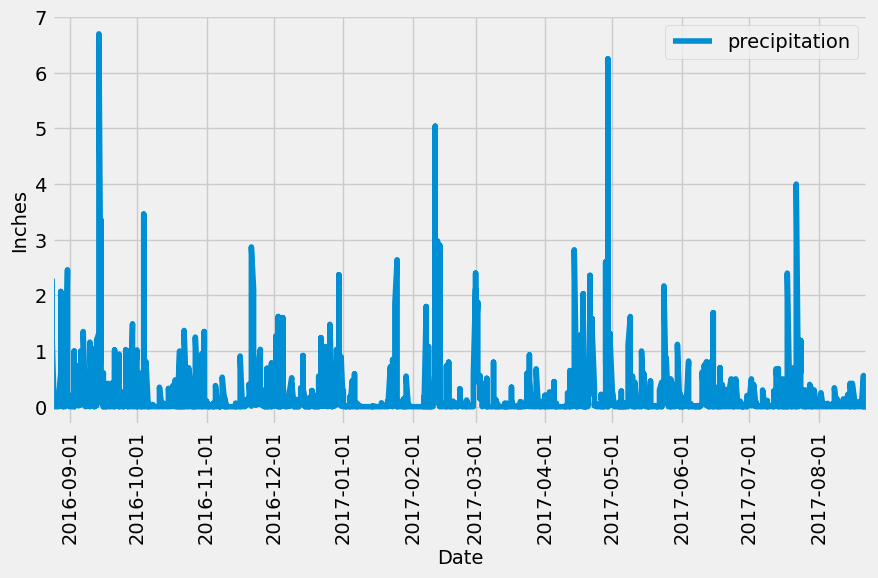

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Starting from the most recent data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

# Calculate the date one year from the last date in the data set
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
select_measurements = [measurement.date, measurement.prcp]
precipitation = session.query(*select_measurements).\
    filter(func.strftime(measurement.date) >= start_date).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names.
precipitation_df = pd.DataFrame(precipitation, columns=['date', 'prcp'])
precipitation_df.dropna(axis=0, how='any', inplace=True)

# Convert the 'date' column to datetime objects
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

# Sort the DataFrame by date
precipitation_df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with matplotlib to plot the data
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(precipitation_df['date'], precipitation_df['prcp'])

# Format the date on the X-axis as "YYYY-MM-DD"
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the x-axis labels vertically
plt.xticks(rotation='vertical')

# Set the x-axis range to start at the earliest date in the dataset
earliest_date = precipitation_df['date'].min()
latest_date = precipitation_df['date'].max()
ax.set_xlim(earliest_date, latest_date)

# Set the x-axis label, y-axis label, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.legend(['precipitation'], loc='upper right')

plt.tight_layout()
plt.show()


In [34]:
# Use pandas to calculate the summary statistics for the precipitation data
''' Excludes records with no prcp entry, which is why the count here is less than the count in the starter code section '''
''' Dropping these NA values makes the most sense to me when calculating sumaary statistics for precipitation'''
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(distinct(measurement.station))).all()

[(9,)]

In [36]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order
select_active = [measurement.station, 
       func.count(measurement.date)]
active_stations = session.query(*select_active).\
        group_by(measurement.station).\
        order_by(func.count(measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature
most_active_station_id = active_stations[0][0]
select_queries = [measurement.station,
       func.min(measurement.tobs), 
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]
station_temp_summary = session.query(*select_queries).\
        filter(measurement.station == most_active_station_id).\
        group_by(measurement.station).\
        first()

# Answer the question from the assignment instructions on the most active station
print(f"Station ID {most_active_station_id} has the most observations. Here are the minimum, maximum, and average temperatures for that station:")

# Print the results of the query
temperature_summary = tuple(station_temp_summary[1:])  # Wrap temperature values in a tuple
print([temperature_summary])  # Print the list containing the tuple

Station ID USC00519281 has the most observations. Here are the minimum, maximum, and average temperatures for that station:
[(54.0, 85.0, 71.66378066378067)]


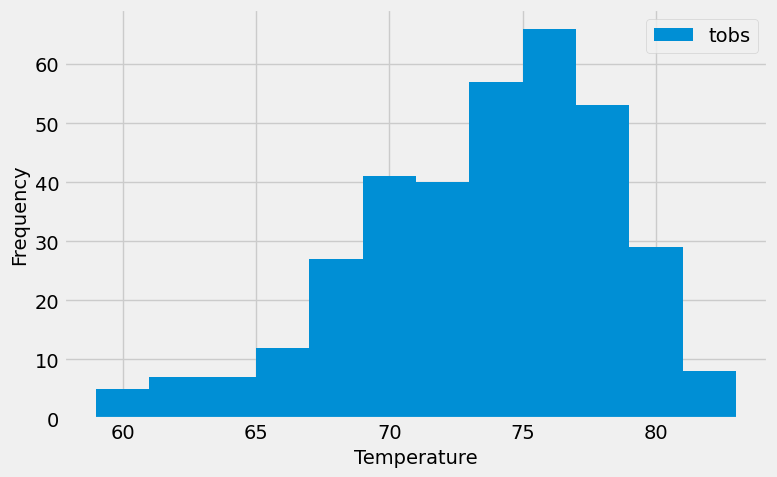

In [38]:
# Convert the start_date to a string in the format 'YYYY-MM-DD'
start_date_str = start_date.strftime('%Y-%m-%d')

# Query the last 12 months of temperature observation data for this station
data = session.query(measurement.tobs).\
        filter(measurement.station == most_active_station_id).\
        filter(measurement.date >= start_date_str).all()

# Save the query results as a Pandas DataFrame
station_df = pd.DataFrame(data, columns=['tobs'])

# Plot the results as a histogram
fig, ax = plt.subplots(figsize=(8, 5))
station_df.plot.hist(ax=ax, bins=12, label="TOBS") # Use bins = 12 per the instructions
ax.set_xlabel('Temperature')
ax.legend()

plt.tight_layout()
plt.show()


# Close Session

In [39]:
# Close Session
session.close()